In [2]:
# prompt:

# This is a valid Python code snippet.


## Загружаем и анализируем данные

In [3]:
!!pip install catboost

['Collecting catboost',
 '  Downloading catboost-1.2.2-cp310-cp310-manylinux2014_x86_64.whl (98.7 MB)',
 '\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/98.7 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.1/98.7 MB\x1b \x1b2.1 MB/s\x1b eta \x1b0:00:48\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.3/98.7 MB\x1b \x1b4.7 MB/s\x1b eta \x1b0:00:21\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.6/98.7 MB\x1b \x1b5.6 MB/s\x1b eta \x1b0:00:18\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b1.0/98.7 MB\x1b \x1b7.0 MB/s\x1b eta \x1b0:00:14\x1b',
 '\x1b[2K     \x1b╸\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b1.5/98.7 MB\x1b \x1b8.3 MB/s\x1b eta \x1b0:00:12\x1b',
 '\x1b[2K     \x1b╸\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b2.0/98.7 MB\x1b \x1b9.3 MB/s\x1b eta \x1b0:00:11\x1b',
 '\x1b[2K     \x1b━\x1b\x1b╺\x1

In [4]:
import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_log_error

In [5]:
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.3 MB/s eta 0:00:00


In [6]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.2 MB/s eta 0:00:00


In [7]:
import pathlib
import pickle
from datetime import datetime, timedelta
from tqdm import tqdm
import dill


from category_encoders import OneHotEncoder
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator
from tqdm import tqdm
import lightgbm as lgb

In [8]:
!pip install chardet

In [9]:
random.seed(42) # фиксируем воспроизводимость
%matplotlib inline
import chardet

In [355]:
data = pd.read_csv('/content/drive/MyDrive/Data/sc2021_train_deals.csv', parse_dates=["month", "date"])

data.head()

,material_code,company_code,country,region,manager_code,month,material_lvl1_name,material_lvl2_name,material_lvl3_name,contract_type,date,volume
0,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-01,43.0
1,197,0,Китай,Китай,16350,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,95.0
2,794,2162,Казахстан,Атырауская обл.,10942,2018-01-01,Базовые полимеры,ПП,ПП,Контракт,2018-01-02,57.0
3,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,21.0
4,133,0,Китай,Китай,17745,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,150.0


In [211]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92306 entries, 0 to 92305
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   material_code       92306 non-null  int64         
 1   company_code        92306 non-null  int64         
 2   country             92306 non-null  object        
 3   region              92306 non-null  object        
 4   manager_code        92306 non-null  int64         
 5   month               92306 non-null  datetime64[ns]
 6   material_lvl1_name  92306 non-null  object        
 7   material_lvl2_name  92306 non-null  object        
 8   material_lvl3_name  92306 non-null  object        
 9   contract_type       92306 non-null  object        
 10  date                92306 non-null  datetime64[ns]
 11  volume              92306 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 8.5+ MB


In [212]:
data.describe()

,material_code,company_code,manager_code,volume
count,92306.000000,92306.000000,92306.000000,92306.000000
mean,430.662752,3736.563831,14589.355687,33.490131
std,237.791293,3283.773053,2412.087205,46.954516
min,124.000000,0.000000,10642.000000,1.000000
25%,214.000000,0.000000,12444.000000,20.000000
50%,443.000000,3342.000000,14676.000000,20.000000
75%,576.000000,6459.000000,16156.000000,32.000000
max,998.000000,9961.000000,19906.000000,1623.000000


### Проверяем пропуски

In [213]:
data.isnull().sum()

material_code         0
company_code          0
country               0
region                0
manager_code          0
month                 0
material_lvl1_name    0
material_lvl2_name    0
material_lvl3_name    0
contract_type         0
date                  0
volume                0
dtype: int64

In [214]:
print(data.isna().any())

material_code         False
company_code          False
country               False
region                False
manager_code          False
month                 False
material_lvl1_name    False
material_lvl2_name    False
material_lvl3_name    False
contract_type         False
date                  False
volume                False
dtype: bool


### Смотрим первичные графики

In [215]:
# временной диапазон выборки
min_date = data['date'].dt.strftime('%Y-%m-%d').min()
max_date = data['date'].dt.strftime('%Y-%m-%d').max()
min_date, max_date

('2018-01-01', '2020-07-31')

<Axes: xlabel='date'>

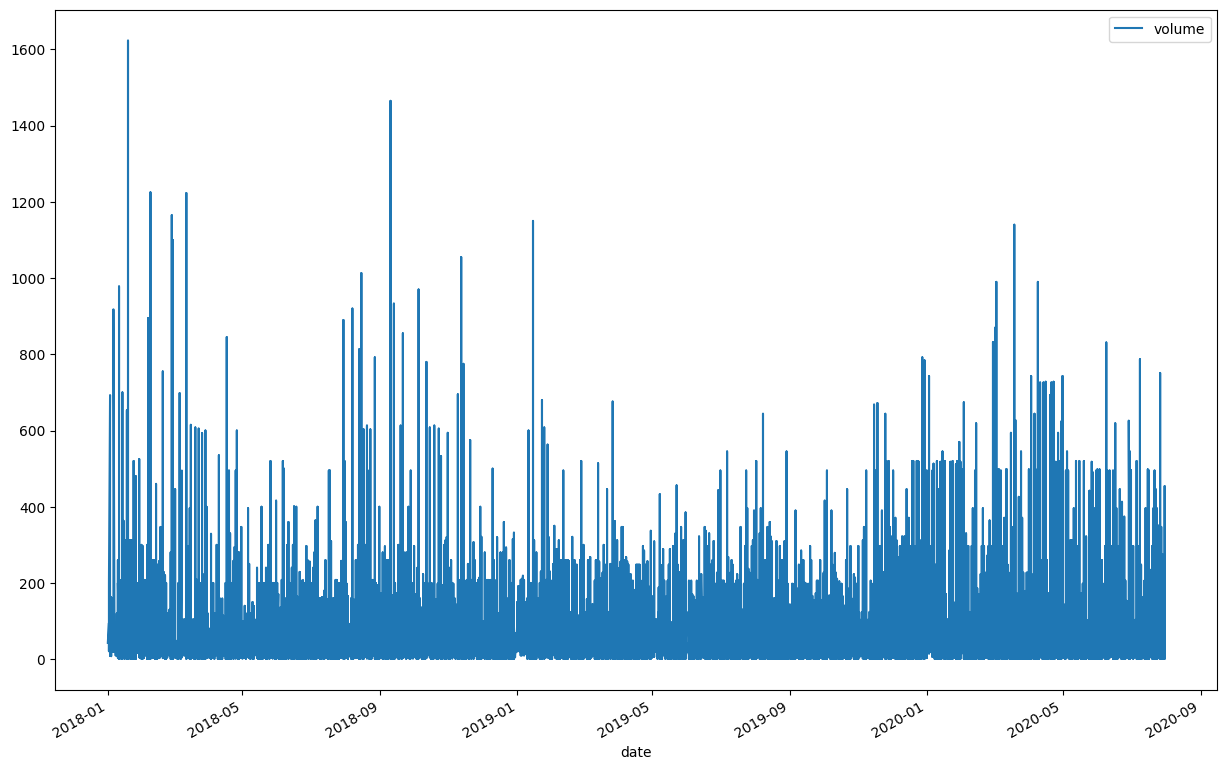

In [216]:
data.plot(x = "date", y = "volume", figsize = (15,10))

### чуть сгладим

<Axes: xlabel='month'>

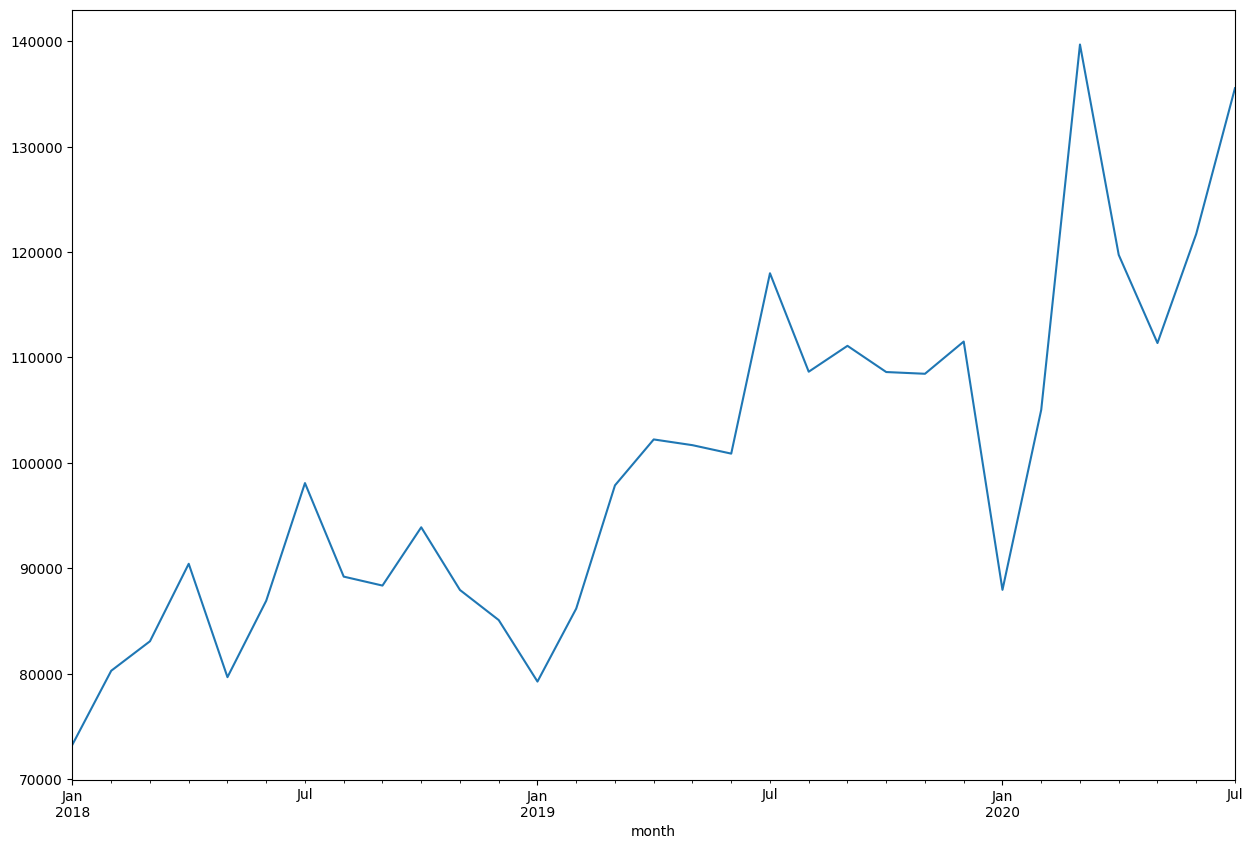

In [217]:
data.groupby(["month"])["volume"].sum().plot(x = "month", y = "volume", figsize = (15,10))

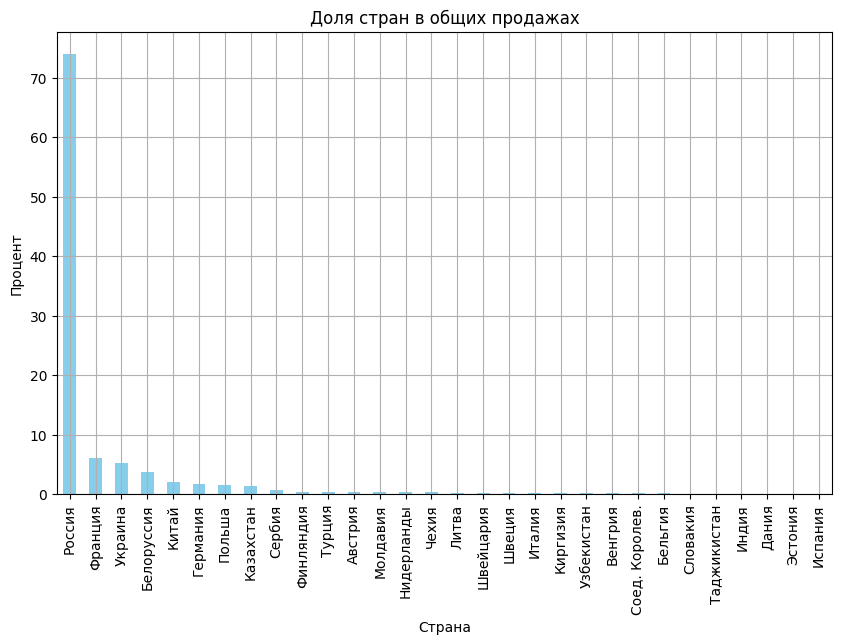

In [218]:
relative_frequencies = data['country'].value_counts(normalize=True) * 100

# Строим график
plt.figure(figsize=(10, 6))
relative_frequencies.plot(kind='bar', color='skyblue')
plt.xlabel('Страна')
plt.ylabel('Процент')
plt.title('Доля стран в общих продажах')
plt.grid(True)
plt.show()

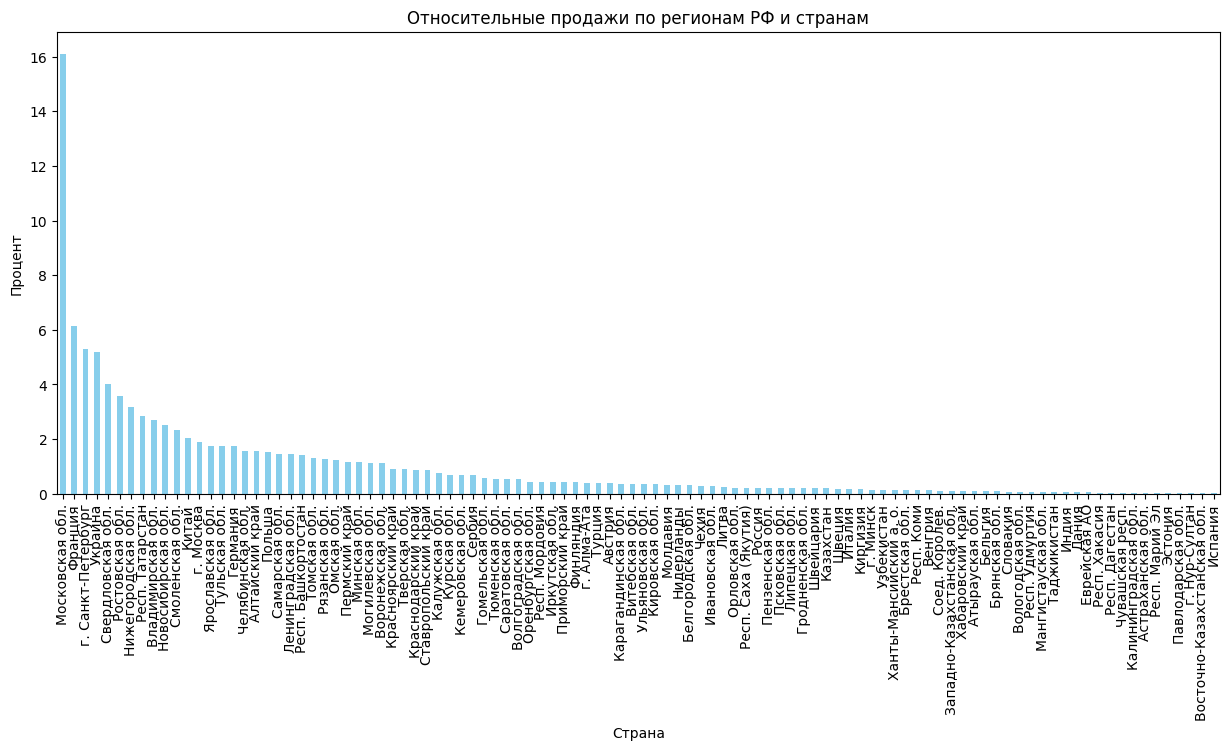

In [219]:
# детализируем
relative_frequencies_2 = data['region'].value_counts(normalize=True) * 100

# Строим график
plt.figure(figsize=(15, 6))
relative_frequencies_2.plot(kind='bar', color='skyblue')
plt.xlabel('Страна')
plt.ylabel('Процент')
plt.title('Относительные продажи по регионам РФ и странам')
plt.show()

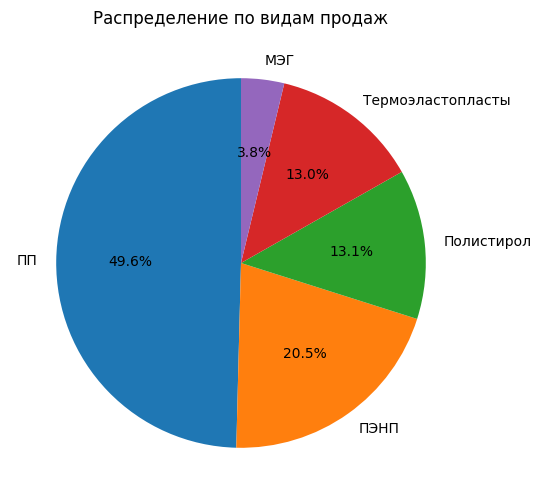

In [220]:
sales_product = data['material_lvl3_name'].value_counts(normalize=True) * 100

# Строим график
plt.figure(figsize=(15, 6))
plt.pie(sales_product, labels=sales_product.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение по видам продаж')
plt.show()

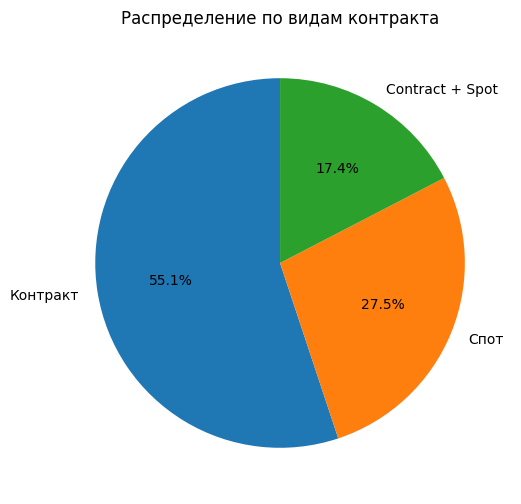

In [221]:
sales_contract = data['contract_type'].value_counts(normalize=True) * 100

# Строим график
plt.figure(figsize=(15, 6))
plt.pie(sales_contract, labels=sales_contract.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение по видам контракта')
plt.show()

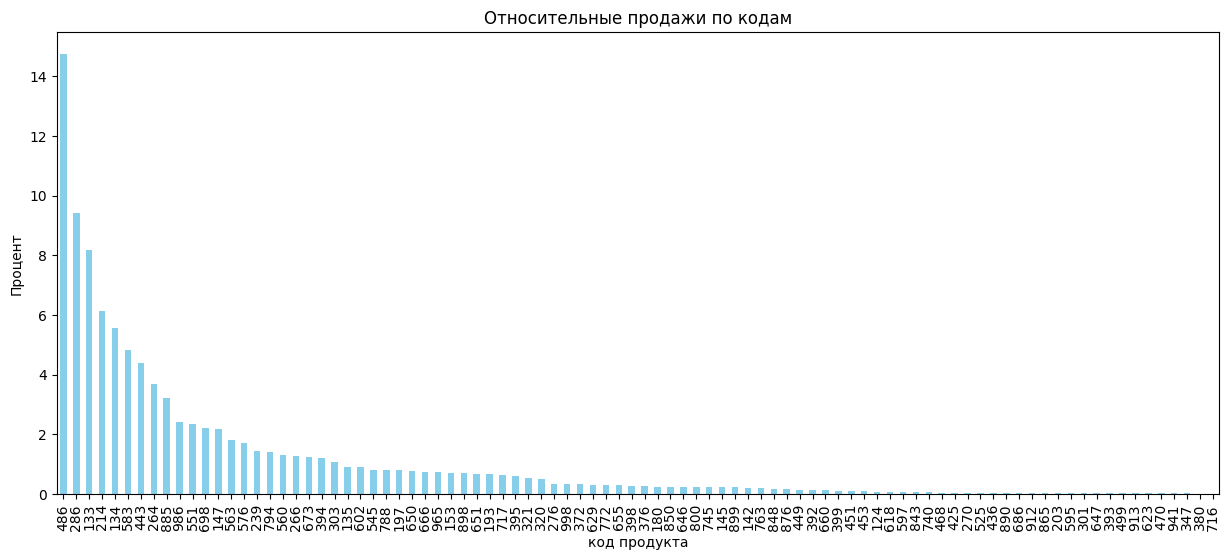

In [222]:
sales_code = data['material_code'].value_counts(normalize=True) * 100

plt.figure(figsize=(15, 6))
sales_code.plot(kind='bar', color='skyblue')
plt.xlabel('код продукта')
plt.ylabel('Процент')
plt.title('Относительные продажи по кодам')
plt.show()

### как видим, основные продажи приходятся на РФ - больше 70%. При этом Московская область приходится 16% всех продаж. Крупнейший импортер - Франция около 8%. Почти 50% всех продаж - это полипропилен. Основные продажи пришлись на долгосрочные контракты - 55%


<Figure size 640x480 with 0 Axes>

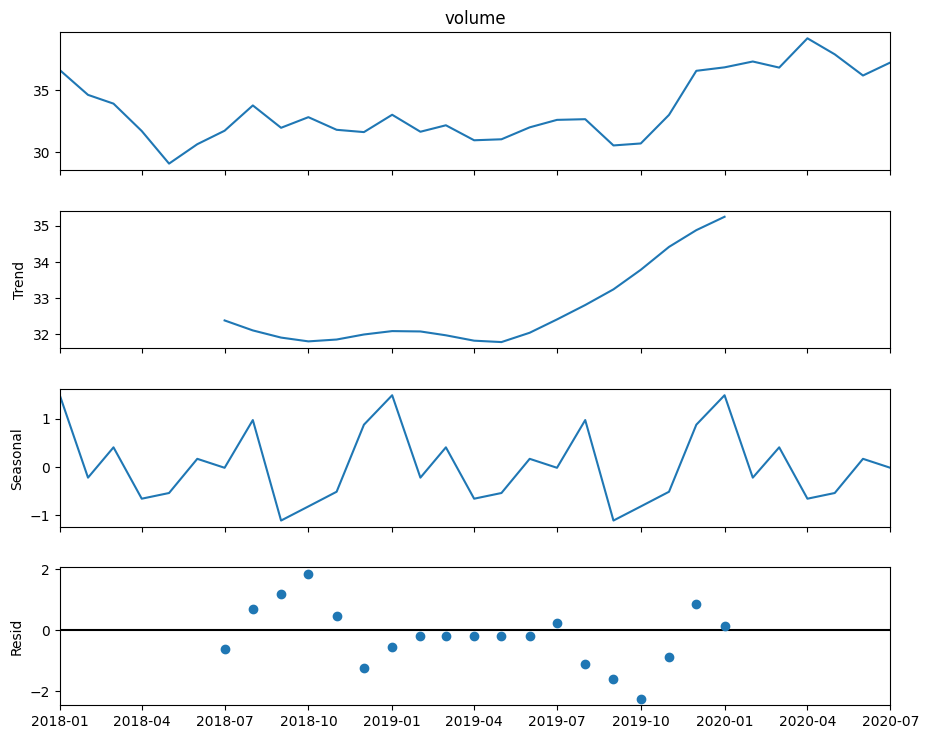

In [223]:
train_plot = data.set_index('date')
y = train_plot['volume'].resample('MS').mean()

result = sm.tsa.seasonal_decompose(y, model='additive')
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(10, 8)

## Feature engineering

- временные метки: лаги на 3/6/12/18 месяцев
- скользящие среднее/минимум/максиму в периоде 3/6/12/18 месяце
- получение признаков на основе дат праздников
- признаки на основе OneHot

Во избежание переобучения, будем добавлять к каждому значению шум.

In [356]:


key_cols = ["material_code", "company_code", "country", "region", "manager_code", "contract_type"]
cat_cols = ['material_lvl1_name', 'material_lvl2_name', 'material_lvl3_name']

FOLDS = 5



In [397]:
group_ts = data.groupby(key_cols + ['month'])['volume'].sum().unstack(fill_value=0)

group_ts

month                                                                                  2018-01-01  \
material_code company_code country    region             manager_code contract_type                 
124           7278         Россия     Респ. Татарстан    17460        Contract + Spot       340.0   
133           0            Белоруссия Минская обл.       10942        Спот                    0.0   
                                      Могилевская обл.   10942        Спот                    0.0   
                                      г. Минск           10942        Спот                    0.0   
                           Казахстан  г. Нур-Султан      13301        Спот                    0.0   
...                                                                                           ...   
986           9943         Россия     Смоленская обл.    17460        Контракт                0.0   
998           0            Россия     Ленинградская обл. 18079        Спот                    0.0   
              3380         Россия     Ленинградская обл. 14956        Контракт                0.0   
              5410         Россия     г. Санкт-Петербург 14956        Контракт               60.0   
              6346         Россия     Респ. Башкортостан 10737        Контракт                0.0   

month                                                                                  2018-02-01  \
material_code company_code country    region             manager_code contract_type                 
124           7278         Россия     Респ. Татарстан    17460        Contract + Spot       340.0   
133           0            Белоруссия Минская обл.       10942        Спот                    0.0   
                                      Могилевская обл.   10942        Спот                    0.0   
                                      г. Минск           10942        Спот                   20.0   
                           Казахстан  г. Нур-Султан      13301        Спот                    0.0   
...                                                                                           ...   
986           9943         Россия     Смоленская обл.    17460        Контракт                0.0   
998           0            Россия     Ленинградская обл. 18079        Спот                    0.0   
              3380         Россия     Ленинградская обл. 14956        Контракт                0.0   
              5410         Россия     г. Санкт-Петербург 14956        Контракт               60.0   
              6346         Россия     Респ. Башкортостан 10737        Контракт                0.0   

month                                                                                  2018-03-01  \
material_code company_code country    region             manager_code contract_type                 
124           7278         Россия     Респ. Татарстан    17460        Contract + Spot       260.0   
133           0            Белоруссия Минская обл.       10942        Спот                    0.0   
                                      Могилевская обл.   10942        Спот                    0.0   
                                      г. Минск           10942        Спот                    0.0   
                           Казахстан  г. Нур-Султан      13301        Спот                   30.0   
...                                                                                           ...   
986           9943         Россия     Смоленская обл.    17460        Контракт                0.0   
998           0            Россия     Ленинградская обл. 18079        Спот                    0.0   
              3380         Россия     Ленинградская обл. 14956        Контракт                0.0   
              5410         Россия     г. Санкт-Петербург 14956        Контракт              100.0   
              6346         Россия     Респ. Башкортостан 10737        Контракт                0.0   

month                                                     

In [411]:
df = pd.DataFrame(group_ts.stack()).reset_index()

df = df.rename(columns={0: 'volume'})
df['volume'] = np.log1p(df['volume'])
df.head()

,material_code,company_code,country,region,manager_code,contract_type,month,volume
0,124,7278,Россия,Респ. Татарстан,17460,Contract + Spot,2018-01-01,5.831882
1,124,7278,Россия,Респ. Татарстан,17460,Contract + Spot,2018-02-01,5.831882
2,124,7278,Россия,Респ. Татарстан,17460,Contract + Spot,2018-03-01,5.564520
3,124,7278,Россия,Респ. Татарстан,17460,Contract + Spot,2018-04-01,5.484797
4,124,7278,Россия,Респ. Татарстан,17460,Contract + Spot,2018-05-01,5.398163


In [359]:
class FeatureEngineering:
  """
  Создает новые признаки:
  1. Lag признаки;
  2. Скользящие средние;
  """

  def __init__(self, df):
    self.df = df

  # генерация случайного шума случайный шум
  def random_noise(self):
      return np.abs(np.random.normal(scale=0.1, size=(len(self.df),)))

  # lag признаки
  def lag_features(self):
    lags = [1, 2, 3, 6, 9, 10, 12, 15]
    for lag in lags:
      self.df['sales_lag_' + str(lag)] = self.df.groupby(key_cols)['volume'].transform(
          lambda x: x.shift(lag)) + self.random_noise() # Adding random noise to each value.

    return self.df

  # скользящие аггрегированные признаки
  def roll_agg_features(self):
    windows = [1, 2, 3, 6, 9, 10, 12, 15]
    for window in windows:
        self.df['sales_roll_mean_' + str(window)] = self.df.groupby(key_cols)['volume']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window,
                                         min_periods=1,
                                         win_type="triang").mean()) + self.random_noise()

        self.df['sales_roll_max_' + str(window)] = self.df.groupby(key_cols)['volume']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window,
                                         min_periods=1).max()) + self.random_noise()

        self.df['sales_roll_min_' + str(window)] = self.df.groupby(key_cols)['volume']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window,
                                         min_periods=1).min()) + self.random_noise()

    return self.df





  # применение методов
  def transform(self):
    self.df = self.lag_features()
    self.df = self.roll_agg_features()


    return self.df

In [360]:
# применим класс к датасету
fe_data = FeatureEngineering(df).transform()

In [345]:
fe_data

,material_code,company_code,country,region,manager_code,contract_type,month,volume,sales_lag_3,sales_lag_6,...,sales_roll_max_2,sales_roll_min_2,sales_lag_10,sales_lag_15,sales_roll_mean_10,sales_roll_max_10,sales_roll_min_10,sales_roll_mean_15,sales_roll_max_15,sales_roll_min_15
0,124,7278,Россия,Респ. Татарстан,17460,Contract + Spot,2018-01-01,5.831882,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,124,7278,Россия,Респ. Татарстан,17460,Contract + Spot,2018-02-01,5.831882,NaN,NaN,...,5.862759,5.838239,NaN,NaN,5.861262,5.875756,5.917243,5.954193,5.848171,5.944327
2,124,7278,Россия,Респ. Татарстан,17460,Contract + Spot,2018-03-01,5.564520,NaN,NaN,...,5.982998,5.969144,NaN,NaN,5.881576,5.895174,5.982066,5.898926,6.072485,5.971245
3,124,7278,Россия,Респ. Татарстан,17460,Contract + Spot,2018-04-01,5.484797,5.934351,NaN,...,5.979480,5.576297,NaN,NaN,5.817091,5.844095,5.605687,5.806595,5.915897,5.565451
4,124,7278,Россия,Респ. Татарстан,17460,Contract + Spot,2018-05-01,5.398163,5.935038,NaN,...,5.627004,5.640757,NaN,NaN,5.788568,5.872759,5.508744,5.762489,5.864525,5.544707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29228,998,6346,Россия,Респ. Башкортостан,10737,Контракт,2020-03-01,3.044522,3.878625,3.050807,...,3.731253,0.026326,3.366951,0.051729,2.707348,3.850154,0.035752,2.013329,3.798680,0.136682
29229,998,6346,Россия,Респ. Башкортостан,10737,Контракт,2020-04-01,3.713572,3.720196,3.788102,...,3.046105,0.046225,0.031125,0.051672,2.922601,3.881766,0.030275,2.394630,3.745372,0.027481
29230,998,6346,Россия,Респ. Башкортостан,10737,Контракт,2020-05-01,3.044522,0.039081,3.725696,...,3.718170,3.085556,3.055097,0.027521,3.017333,3.749464,0.032410,2.514613,3.796363,0.012578
29231,998,6346,Россия,Респ. Башкортостан,10737,Контракт,2020-06-01,3.091042,3.151693,3.810911,...,3.881711,3.100899,0.068032,3.235412,2.999676,3.773428,0.079195,2.642627,3.847504,0.199229


In [361]:
# периоды тренировочной, валидационной и тестовой выборок
tr_range = pd.date_range("2019-01-01", "2019-10-01", freq="MS")
val_range = pd.date_range("2019-11-01", "2020-02-01", freq="MS")
ts_range = pd.date_range("2020-03-01", "2020-07-01", freq="MS")

In [362]:
# разбиение на тренировочную, валидационную  и тренировочную выборки
train_data = fe_data[fe_data['month'].isin(tr_range)]
val_data = fe_data[fe_data['month'].isin(val_range)]
test_data = fe_data[fe_data['month'].isin(ts_range)]

In [363]:
# категориальные колонки
CAT_COLS = ["material_code", "company_code", "country", "region", "manager_code", "month", "contract_type"]
# обучающие признаки
FTS_COLS = fe_data.drop(['volume'], axis=1).columns
# целевая переманная
TARGET = "volume"
# type(month) -> str
train_data['month'] = train_data['month'].astype(str)
val_data['month'] = val_data['month'].astype(str)
test_data['month'] = test_data['month'].astype(str)

assert train_data['month'].dtypes == 'object', "['month'].dtypes должен быть str"
assert val_data['month'].dtypes == 'object', "['month'].dtypes должен быть str"
assert test_data['month'].dtypes == 'object', "['month'].dtypes должен быть str"

<ipython-input-363-6ca9db97ec6f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['month'] = train_data['month'].astype(str)
<ipython-input-363-6ca9db97ec6f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['month'] = val_data['month'].astype(str)
<ipython-input-363-6ca9db97ec6f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [364]:
X_train = train_data[FTS_COLS]
X_val = val_data[FTS_COLS]
X_test = test_data[FTS_COLS]

y_train = train_data[TARGET]
y_val = val_data[TARGET]
y_test = test_data[TARGET]

In [365]:
# инициализация модели
model = CatBoostRegressor(iterations=10000,
                          early_stopping_rounds=100,
                          depth=6,
                          cat_features=CAT_COLS,
                          random_state=82736,
                          verbose=50
                          )
# обучение модели
model.fit(X_train, y_train, eval_set=(X_val, y_val))

Learning rate set to 0.017778
0:	learn: 2.1949685	test: 2.2011314	best: 2.2011314 (0)	total: 31.7ms	remaining: 5m 17s
50:	learn: 1.6578611	test: 1.7799610	best: 1.7799610 (50)	total: 1.45s	remaining: 4m 42s
100:	learn: 1.5218966	test: 1.6906047	best: 1.6906047 (100)	total: 2.83s	remaining: 4m 37s
150:	learn: 1.4791518	test: 1.6745412	best: 1.6745412 (150)	total: 4.18s	remaining: 4m 32s
200:	learn: 1.4580373	test: 1.6730791	best: 1.6721511 (177)	total: 6.11s	remaining: 4m 57s
250:	learn: 1.4448354	test: 1.6746414	best: 1.6721511 (177)	total: 8.39s	remaining: 5m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.672151084
bestIteration = 177

Shrink model to first 178 iterations.


In [366]:
# прогноз
train_preds = np.expm1(model.predict(X_train))
val_preds = np.expm1(model.predict(X_val))
test_preds = np.expm1(model.predict(X_test))

# оценка модели
print("RMSLE на тренировочной выборке:",
      f'{mean_squared_log_error(np.expm1(y_train), train_preds, squared=False):.4f}')
print("RMSLE на валидационной выборке:",
      f'{mean_squared_log_error(np.expm1(y_val), val_preds, squared=False):.4f}')
print("RMSLE на тестовой выборке:",
      f'{mean_squared_log_error(np.expm1(y_test), test_preds, squared=False):.4f}')

RMSLE на тренировочной выборке: 1.4629
RMSLE на валидационной выборке: 1.6722
RMSLE на тестовой выборке: 1.7436


In [367]:
feature_importance = pd.Series(model.feature_importances_, index=FTS_COLS).sort_values(ascending=False)

<ipython-input-368-5125f2ca7382>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


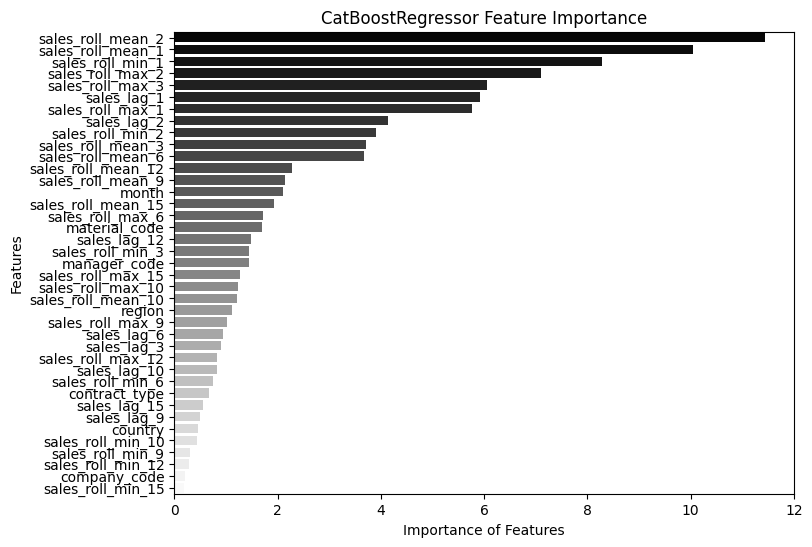

In [368]:
plt.figure(figsize=(8, 6))
sns.barplot(
    x=feature_importance.values,
    y=feature_importance.index,
    palette='gray'
    )
plt.title('CatBoostRegressor Feature Importance')
plt.xlabel('Importance of Features')
plt.ylabel('Features')
plt.show()

In [369]:
from sklearn.model_selection import TimeSeriesSplit

In [370]:
# инициализация базовой модели
base_model = CatBoostRegressor(iterations=10000,
                              early_stopping_rounds=100,
                              depth=6,
                              cat_features=CAT_COLS,
                              random_state=82736,
                              verbose=100)

In [371]:
# количество сплитов
splits = 5
# randon state
RS = 82736
# инициализация cv-модели
ts_cv = TimeSeriesSplit(n_splits=splits, test_size=941*2)
# список для хранения ошибок
ts_cv_losses = []
# month.dtypes -> str
fe_data['month'] = fe_data['month'].astype(str)

for fold, (train_idx, test_idx) in enumerate(ts_cv.split(fe_data)):
    print(f'    Фолд {fold}\n')
    # разбиваем выборку на трейн/тест
    X_train = fe_data[FTS_COLS].iloc[train_idx]
    X_test = fe_data[FTS_COLS].iloc[test_idx]
    y_train = fe_data[TARGET].iloc[train_idx]
    y_test = fe_data[TARGET].iloc[test_idx]
    # обучаемая модель
    model = CatBoostRegressor(iterations=10000,
                              early_stopping_rounds=100,
                              depth=6,
                              cat_features=CAT_COLS,
                              random_state=RS * fold,
                              verbose=100)
    # обучение модели
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    # прогноз
    ts_pred = np.expm1(model.predict(X_test))
    # ошибка
    test_loss = np.sqrt(mean_squared_log_error(np.expm1(y_test), ts_pred))

    ts_cv_losses.append(test_loss)

    print(f'\nRMSLE:{test_loss: .4f}\n')

    # сохраняем модель
    model.save_model(f"/content/drive/MyDrive/Data/cv_model_{fold}.cbm")

    Фолд 0

Learning rate set to 0.019978
0:	learn: 2.2443083	test: 1.8817139	best: 1.8817139 (0)	total: 46.1ms	remaining: 7m 40s
100:	learn: 1.6017673	test: 1.2875731	best: 1.2875731 (100)	total: 7.91s	remaining: 12m 55s
200:	learn: 1.5513027	test: 1.2553304	best: 1.2553304 (200)	total: 11.8s	remaining: 9m 34s
300:	learn: 1.5339615	test: 1.2495657	best: 1.2495657 (300)	total: 15.7s	remaining: 8m 24s
400:	learn: 1.5190434	test: 1.2478889	best: 1.2477960 (399)	total: 21.3s	remaining: 8m 29s
500:	learn: 1.5067658	test: 1.2493045	best: 1.2473918 (416)	total: 25.4s	remaining: 8m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.247391777
bestIteration = 416

Shrink model to first 417 iterations.

RMSLE: 1.2474

    Фолд 1

Learning rate set to 0.020264
0:	learn: 2.2152539	test: 2.2730768	best: 2.2730768 (0)	total: 79.7ms	remaining: 13m 16s
100:	learn: 1.5748777	test: 1.5491309	best: 1.5460472 (99)	total: 6.71s	remaining: 10m 57s
200:	learn: 1.5265518	test: 1.5088396	best

In [372]:
print(f'Средний RMSLE на тестовой выбокре:{np.mean(ts_cv_losses): .4f}')

Средний RMSLE на тестовой выбокре: 1.5239


In [373]:
def predict(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """
    Вычисление предсказаний.

    Параметры:
        df:
          датафрейм, содержащий все сделки с начала тренировочного периода до `month`;
        month:
          месяц, для которого вычисляются предсказания.

    Результат:
        Датафрейм предсказаний для каждой группы, содержащий колонки:
            - `material_code`, `company_code`, `country`, `region`, `manager_code`,
            - `prediction`.
        Предсказанные значения находятся в колонке `prediction`.
    """

    group_ts = df.groupby(key_cols + ["month"])["volume"].sum().unstack(fill_value=0)
    group_ts[month] = 0
    new_df = pd.DataFrame(group_ts.stack()).reset_index()
    new_df = new_df.rename(columns={0: 'volume'})
    new_df['volume'] = np.log1p(new_df['volume'])
    fe_data = FeatureEngineering(new_df).transform()
    fe_data['month'] = fe_data['month'].astype(str)

    predicting_data = fe_data[fe_data['month'] == str(month)[:10]].reset_index()

    model = CatBoostRegressor()
    predictions = pd.DataFrame()
    for i in range(FOLDS):
      model_path = f'/content/drive/MyDrive/Data/cv_model_{i}.cbm'
      model.load_model(model_path)
      prediction = model.predict(predicting_data[model.feature_names_])
      predictions[f'prediction_{i}'] = prediction

    preds_df = predicting_data[key_cols].copy()
    preds_df["prediction"] = np.expm1(np.mean(predictions, axis=1))

    return preds_df

In [178]:
from catboost import CatBoostRegressor

In [386]:
data_pred = predict(data, pd.Timestamp("2020-08-01"))
data_pred.head()

,material_code,company_code,country,region,manager_code,contract_type,prediction
0,124,7278,Россия,Респ. Татарстан,17460,Contract + Spot,0.906009
1,133,0,Белоруссия,Минская обл.,10942,Спот,129.989436
2,133,0,Белоруссия,Могилевская обл.,10942,Спот,2.487572
3,133,0,Белоруссия,г. Минск,10942,Спот,2.687680
4,133,0,Казахстан,г. Нур-Султан,13301,Спот,5.958482


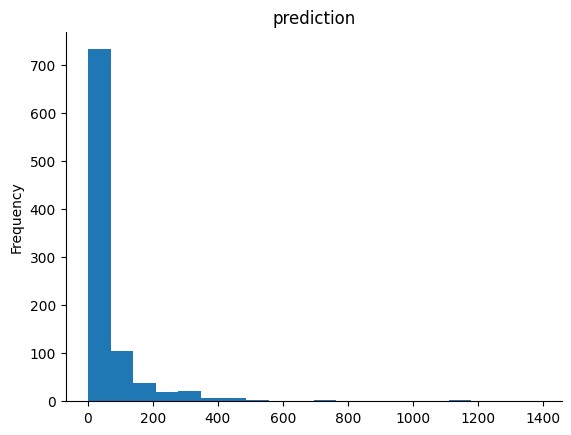

In [415]:
# @title prediction

from matplotlib import pyplot as plt
data_pred['prediction'].plot(kind='hist', bins=20, title='prediction')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [378]:
data_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   material_code  943 non-null    int64  
 1   company_code   943 non-null    int64  
 2   country        943 non-null    object 
 3   region         943 non-null    object 
 4   manager_code   943 non-null    int64  
 5   contract_type  943 non-null    object 
 6   prediction     943 non-null    float64
dtypes: float64(1), int64(3), object(3)
memory usage: 51.7+ KB
